#Import Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

try:
  import mesa
except:
  !pip install mesa==2.1.4 --quiet
import mesa


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.2 MB/s eta 0:00:00
     

In [ ]:
#import mesa
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from mesa import Agent, Model
from mesa.space import MultiGrid


# Resource Agents2

In [ ]:
class Resource(mesa.Agent):
    """
    Resource:
    - contains an amount of sugar and spice
    - grows 1 amount of sugar at each turn
    - grows 1 amount of spice at each turn
    """

    def __init__(self, unique_id, model, pos, max_sugar, max_spice):
        super().__init__(unique_id, model)
        self.pos = pos
        self.sugar_amount = max_sugar
        self.max_sugar = max_sugar
        self.spice_amount = max_spice
        self.max_spice = max_spice

    def step(self):
        """
        Growth function, adds one unit of sugar and spice each step up to
        max amount
        """
        self.sugar_amount = min([self.max_sugar, self.sugar_amount + 1])
        self.spice_amount = min([self.max_spice, self.spice_amount + 1])

#Trader Class2


In [ ]:
#from .resource_agents import Resource


# Helper function
def get_distance(pos_1, pos_2):
    """
    Calculate the Euclidean distance between two positions

    used in trade.move()
    """

    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx**2 + dy**2)


class Trader(mesa.Agent):
    """
    Trader:
    - has a metabolism of sugar and spice
    - harvest and trade sugar and spice to survive
    """

    def __init__(
        self,
        unique_id,
        model,
        pos,
        moore=False,
        sugar=0,
        spice=0,
        metabolism_sugar=0,
        metabolism_spice=0,
        vision=0,
    ):
        super().__init__(unique_id, model)
        self.pos = pos
        self.moore = moore
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision
        self.prices = []
        self.trade_partners = []

    def get_resource(self, pos):
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Resource:
                return agent
        raise Exception(f"Resource agent not found in the position {pos}")

    def get_trader(self, pos):
        """
        helper function used in self.trade_with_neighbors()
        """

        this_cell = self.model.grid.get_cell_list_contents(pos)

        for agent in this_cell:
            if isinstance(agent, Trader):
                return agent

    def is_occupied_by_other(self, pos):
        """
        helper function part 1 of self.move()
        """

        if pos == self.pos:
            # agent's position is considered unoccupied as agent can stay there
            return False
        # get contents of each cell in neighborhood
        this_cell = self.model.grid.get_cell_list_contents(pos)
        return any(isinstance(a, Trader) for a in this_cell)

    def calculate_welfare(self, sugar, spice):
        """
        helper function

        part 2 self.move()
        self.trade()
        """

        # calculate total resources
        m_total = self.metabolism_sugar + self.metabolism_spice
        # Cobb-Douglas functional form; starting on p. 97
        # on Growing Artificial Societies
        return sugar ** (self.metabolism_sugar / m_total) * spice ** (
            self.metabolism_spice / m_total
        )

    def is_starved(self):
        """
        Helper function for self.maybe_die()
        """

        return (self.sugar <= 0) or (self.spice <= 0)

    def calculate_MRS(self, sugar, spice):
        """
        Helper function for
          - self.trade()
          - self.maybe_self_spice()

        Determines what trader agent needs and can give up
        """

        return (spice / self.metabolism_spice) / (sugar / self.metabolism_sugar)

    def calculate_sell_spice_amount(self, price):
        """
        helper function for self.maybe_sell_spice() which is called from
        self.trade()
        """

        if price >= 1:
            sugar = 1
            spice = int(price)
        else:
            sugar = int(1 / price)
            spice = 1
        return sugar, spice

    def sell_spice(self, other, sugar, spice):
        """
        used in self.maybe_sell_spice()

        exchanges sugar and spice between traders
        """

        self.sugar += sugar
        other.sugar -= sugar
        self.spice -= spice
        other.spice += spice

    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
        """
        helper function for self.trade()
        """

        sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

        # Assess new sugar and spice amount - what if change did occur
        self_sugar = self.sugar + sugar_exchanged
        other_sugar = other.sugar - sugar_exchanged
        self_spice = self.spice - spice_exchanged
        other_spice = other.spice + spice_exchanged

        # double check to ensure agents have resources

        if (
            (self_sugar <= 0)
            or (other_sugar <= 0)
            or (self_spice <= 0)
            or (other_spice <= 0)
        ):
            return False

        # trade criteria #1 - are both agents better off?
        both_agents_better_off = (
            welfare_self < self.calculate_welfare(self_sugar, self_spice)
        ) and (welfare_other < other.calculate_welfare(other_sugar, other_spice))

        # trade criteria #2 is their mrs crossing with potential trade
        mrs_not_crossing = self.calculate_MRS(
            self_sugar, self_spice
        ) > other.calculate_MRS(other_sugar, other_spice)

        if not (both_agents_better_off and mrs_not_crossing):
            return False

        # criteria met, execute trade
        self.sell_spice(other, sugar_exchanged, spice_exchanged)

        return True

    def trade(self, other):
        """
        helper function used in trade_with_neighbors()

        other is a trader agent object
        """

        # sanity check to verify code is working as expected
        assert self.sugar > 0
        assert self.spice > 0
        assert other.sugar > 0
        assert other.spice > 0

        # calculate marginal rate of substitution in Growing Artificial Societies p. 101
        mrs_self = self.calculate_MRS(self.sugar, self.spice)
        mrs_other = other.calculate_MRS(other.sugar, other.spice)

        # calculate each agents welfare
        welfare_self = self.calculate_welfare(self.sugar, self.spice)
        welfare_other = other.calculate_welfare(other.sugar, other.spice)

        if math.isclose(mrs_self, mrs_other):
            return

        # calcualte price
        price = math.sqrt(mrs_self * mrs_other)

        if mrs_self > mrs_other:
            # self is a sugar buyer, spice seller
            sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
            # no trade - criteria not met
            if not sold:
                return
        else:
            # self is a spice buyer, sugar seller
            sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)
            # no trade - criteria not met
            if not sold:
                return

        # Capture data
        self.prices.append(price)
        self.trade_partners.append(other.unique_id)

        # continue trading
        self.trade(other)

    ######################################################################
    #                                                                    #
    #                      MAIN TRADE FUNCTIONS                          #
    #                                                                    #
    ######################################################################

    def move(self):
        """
        Function for trader agent to identify optimal move for each step in 4 parts
        1 - identify all possible moves
        2 - determine which move maximizes welfare
        3 - find closest best option
        4 - move
        """

        # 1. identify all possible moves

        neighbors = [
            i
            for i in self.model.grid.get_neighborhood(
                self.pos, self.moore, True, self.vision
            )
            if not self.is_occupied_by_other(i)
        ]

        # 2. determine which move maximizes welfare

        welfares = [
            self.calculate_welfare(
                self.sugar + self.get_resource(pos).sugar_amount,
                self.spice + self.get_resource(pos).spice_amount,
            )
            for pos in neighbors
        ]

        # 3. Find closest best option

        # find the highest welfare in welfares
        max_welfare = max(welfares)
        # get the index of max welfare cells
        candidate_indices = [
            i for i in range(len(welfares)) if math.isclose(welfares[i], max_welfare)
        ]

        # convert index to positions of those cells
        candidates = [neighbors[i] for i in candidate_indices]

        min_dist = min(get_distance(self.pos, pos) for pos in candidates)

        final_candidates = [
            pos
            for pos in candidates
            if math.isclose(get_distance(self.pos, pos), min_dist, rel_tol=1e-02)
        ]
        final_candidate = self.random.choice(final_candidates)

        # 4. Move Agent
        self.model.grid.move_agent(self, final_candidate)

    def eat(self):
        patch = self.get_resource(self.pos)
        if patch.sugar_amount > 0:
            self.sugar += patch.sugar_amount
            patch.sugar_amount = 0
        self.sugar -= self.metabolism_sugar

        if patch.spice_amount > 0:
            self.spice += patch.spice_amount
            patch.spice_amount = 0
        self.spice -= self.metabolism_spice

    def maybe_die(self):
        """
        Function to remove Traders who have consumed all their sugar or spice
        """

        if self.is_starved():
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)

    def trade_with_neighbors(self):
        """
        Function for trader agents to decide who to trade with in three parts

        1- identify neighbors who can trade
        2- trade (2 sessions)
        3- collect data
        """

        neighbor_agents = [
            self.get_trader(pos)
            for pos in self.model.grid.get_neighborhood(
                self.pos, self.moore, False, self.vision
            )
            if self.is_occupied_by_other(pos)
        ]

        if len(neighbor_agents) == 0:
            return

            # iterate through traders in neighboring cells and trade
        for a in neighbor_agents:
            if a:
                self.trade(a)

        return

#Model Class 2

In [ ]:
# Helper Functions
def flatten(list_of_lists):
    """
    helper function for model datacollector for trade price
    collapses agent price list into one list
    """
    return [item for sublist in list_of_lists for item in sublist]


def geometric_mean(list_of_prices):
    """
    find the geometric mean of a list of prices
    """
    return np.exp(np.log(list_of_prices).mean())


def get_trade(agent):
    """
    For agent reporters in data collector

    return list of trade partners and None for other agents
    """
    if isinstance(agent, Trader):
        return agent.trade_partners
    else:
        return None


class SugarscapeG1mt(mesa.Model):
    """
    Manager class to run Sugarscape with Traders
    """

    def __init__(
        self,
        width=50,
        height=50,
        initial_population=200,
        endowment_min=25,
        endowment_max=50,
        metabolism_min=1,
        metabolism_max=5,
        vision_min=1,
        vision_max=5,
        enable_trade=True,
    ):
        # Initiate width and heigh of sugarscape
        self.width = width
        self.height = height
        # Initiate population attributes
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max
        self.enable_trade = enable_trade
        self.running = True

        # initiate activation schedule
        self.schedule = mesa.time.RandomActivationByType(self)
        # initiate mesa grid class
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)
        # initiate datacollector
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Trader": lambda m: m.schedule.get_type_count(Trader),
                "Trade Volume": lambda m: sum(
                    len(a.trade_partners)
                    for a in m.schedule.agents_by_type[Trader].values()
                ),
                "Price": lambda m: geometric_mean(
                    flatten(
                        [a.prices for a in m.schedule.agents_by_type[Trader].values()]
                    )
                ),
            },
            agent_reporters={"Trade Network": lambda a: get_trade(a)},
        )

        # read in landscape file from supplmentary material
        sugar_distribution = np.genfromtxt("/content/drive/MyDrive/sugar-map.txt")
        spice_distribution = np.flip(sugar_distribution, 1)

        agent_id = 0
        for _, (x, y) in self.grid.coord_iter():
            max_sugar = sugar_distribution[x, y]
            max_spice = spice_distribution[x, y]
            resource = Resource(agent_id, self, (x, y), max_sugar, max_spice)
            self.schedule.add(resource)
            self.grid.place_agent(resource, (x, y))
            agent_id += 1

        for i in range(self.initial_population):
            # get agent position
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            # see Growing Artificial Societies p. 108 for initialization
            # give agents initial endowment
            sugar = int(self.random.uniform(self.endowment_min, self.endowment_max + 1))
            spice = int(self.random.uniform(self.endowment_min, self.endowment_max + 1))
            # give agents initial metabolism
            metabolism_sugar = int(
                self.random.uniform(self.metabolism_min, self.metabolism_max + 1)
            )
            metabolism_spice = int(
                self.random.uniform(self.metabolism_min, self.metabolism_max + 1)
            )
            # give agents vision
            vision = int(self.random.uniform(self.vision_min, self.vision_max + 1))
            # create Trader object
            trader = Trader(
                agent_id,
                self,
                (x, y),
                moore=False,
                sugar=sugar,
                spice=spice,
                metabolism_sugar=metabolism_sugar,
                metabolism_spice=metabolism_spice,
                vision=vision,
            )
            # place agent
            self.grid.place_agent(trader, (x, y))
            self.schedule.add(trader)
            agent_id += 1

    def randomize_traders(self):
        """
        helper function for self.step()

        puts traders in randomized list for step function
        """

        traders_shuffle = list(self.schedule.agents_by_type[Trader].values())
        self.random.shuffle(traders_shuffle)

        return traders_shuffle

    def step(self):
        """
        Unique step function that does staged activation of sugar and spice
        and then randomly activates traders
        """
        # step Resource agents
        for resource in self.schedule.agents_by_type[Resource].values():
            resource.step()

        # step trader agents
        # to account for agent death and removal we need a seperate data strcuture to
        # iterate
        trader_shuffle = self.randomize_traders()

        for agent in trader_shuffle:
            agent.prices = []
            agent.trade_partners = []
            agent.move()
            agent.eat()
            agent.maybe_die()

        if not self.enable_trade:
            # If trade is not enabled, return early
            self.datacollector.collect(self)
            return

        trader_shuffle = self.randomize_traders()

        for agent in trader_shuffle:
            agent.trade_with_neighbors()

        self.schedule.steps += (
            1  # important for data collector to track number of steps
        )

        # collect model level data
        self.datacollector.collect(self)
        """
        Mesa is working on updating datacollector agent reporter
        so it can collect information on specific agents from
        mesa.time.RandomActivationByType.

        Please see issue #1419 at
        https://github.com/projectmesa/mesa/issues/1419
        (contributions welcome)

        Below is one way to update agent_records to get specific Trader agent data
        """
        # Need to remove excess data
        # Create local variable to store trade data
        agent_trades = self.datacollector._agent_records[self.schedule.steps]
        # Get rid of all None to reduce data storage needs
        agent_trades = [agent for agent in agent_trades if agent[2] is not None]
        # Reassign the dictionary value with lean trade data
        self.datacollector._agent_records[self.schedule.steps] = agent_trades

    def run_model(self, step_count=1000):
        for i in range(step_count):
            self.step()

#Run Sugarscape

In [ ]:
model = SugarscapeG1mt()
model.run_model()


<ipython-input-7-4a74714c381d>:14: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#Analyze data

In [ ]:
results = model.datacollector.get_model_vars_dataframe()
results

,Trader,Trade Volume,Price
0,200,622,0.890157
1,200,98,0.805475
2,200,119,0.952614
3,200,96,0.775208
4,200,122,0.813900
...,...,...,...
995,59,3,0.988957
996,59,16,0.655750
997,59,7,0.991460
998,59,10,0.989443


In [ ]:
# retrieve agent level results
agent_results = model.datacollector.get_agent_vars_dataframe()
# filter out Nones from non-trader agents
agent_results = agent_results[agent_results["Trade Network"].notnull()]
agent_results

Trade Network
Step AgentID                                                   
1    2500     [2575, 2575, 2575, 2575, 2575, 2575, 2575, 257...
     2501                  [2664, 2664, 2664, 2664, 2664, 2665]
     2502            [2569, 2569, 2569, 2569, 2569, 2569, 2569]
     2503                                                    []
     2504     [2550, 2550, 2550, 2550, 2550, 2550, 2550, 255...
...                                                         ...
1000 2668                                                    []
     2675                                                    []
     2681                                                    []
     2682                                                    []
     2690                                                    []

[64995 rows x 1 columns]

<Axes: >

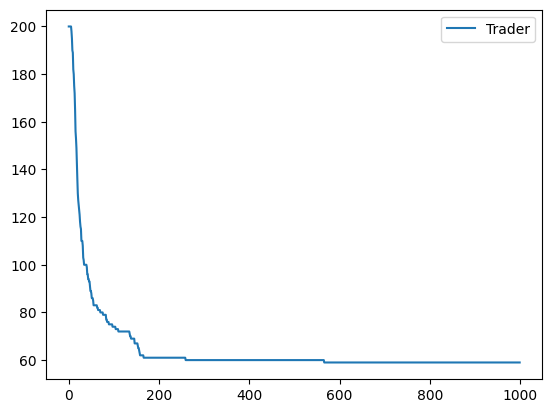

In [ ]:
# plot number of agents per time step
results.plot(y = "Trader", use_index=True)

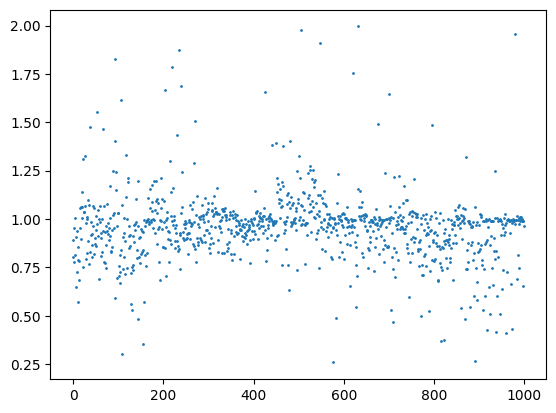

In [ ]:
# plot trade price per step

y = list(results["Price"])
x = range(1000)

plt.scatter(x,y, s=1)

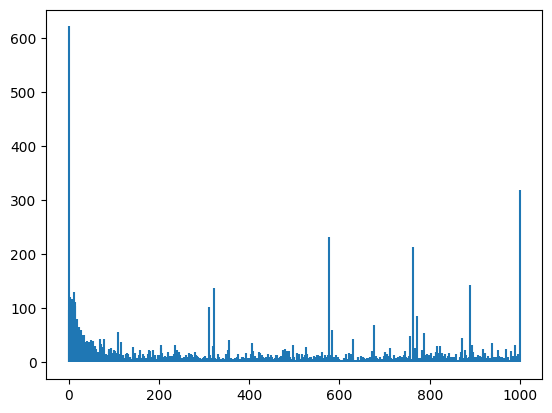

In [ ]:
# Plot trade volume improved

for i in range(1000):
  plt.vlines(i,0,results["Trade Volume"][i])

In [ ]:
# create graph object

G = nx.Graph()

# add agent keys to make initial node set
G.add_nodes_from(list(model.schedule.agents_by_type[Trader].keys()))

# create edge list
for idx, row in agent_results.iterrows():
  if len(row["Trade Network"]) > 0:
    for agent in row["Trade Network"]:
      G.add_edge(idx, agent)

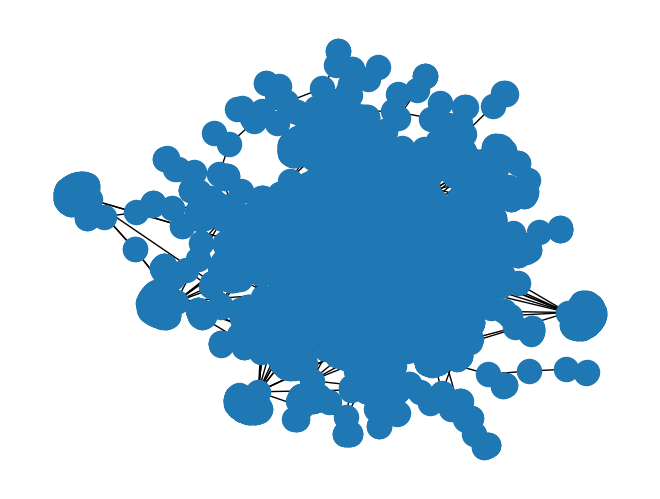

In [ ]:
nx.draw(G)